## Sales Forecasting Prototype: Linear Regression

This notebook explores a linear regression approach to weekly sales forecasting using historical and contextual features. We begin by analyzing Store 1, Department 1 as a prototype. The goal is to understand relationships between features and sales, evaluate model assumptions, and assess performance.

### Data Preparation

We filter the merged dataset to focus on Store 1, Department 1. Weekly sales will be predicted using features like holidays, markdowns, temperature, and CPI. Several calendar and economic features are extracted or cleaned. Weekly sales are log-transformed to normalize the target distribution.

In [1]:
# Data Preparation for Linear Regression (Store 1, Dept 1)

import pandas as pd
import numpy as np

# Load the cleaned, merged dataset
df = pd.read_csv("../data/clean/merged_sales_data.csv", parse_dates=["Date"])

# Filter for Store 1, Dept 1
df_subset = df[(df["Store"] == 1) & (df["Dept"] == 1)].copy()
df_subset = df_subset.sort_values("Date")

# Create calendar/time-based features
df_subset["Week"] = df_subset["Date"].dt.isocalendar().week
df_subset["Month"] = df_subset["Date"].dt.month
df_subset["Year"] = df_subset["Date"].dt.year
df_subset["IsHoliday"] = df_subset["IsHoliday"].astype(int)

# Optional: Add log-transformed sales target
df_subset["log_sales"] = np.log1p(df_subset["Weekly_Sales"])  # log(1 + sales)

# Drop any rows with missing predictors (e.g., in MarkDown columns)
df_subset = df_subset.dropna(subset=[
    "Temperature", "Fuel_Price", "CPI", "Unemployment"
])

# Preview result
df_subset.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month,Week,Year,IsHoliday,log_sales
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,211.096358,8.106,False,2,5,2010,0,10.123647
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,...,NaN,NaN,211.242170,8.106,True,2,6,2010,1,10.737277
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,...,NaN,NaN,211.289143,8.106,False,2,7,2010,0,10.635773
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,...,NaN,NaN,211.319643,8.106,False,2,8,2010,0,9.873262
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,...,NaN,NaN,211.350143,8.106,False,3,9,2010,0,9.990990
5,1,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,NaN,...,NaN,NaN,211.380643,8.106,False,3,10,2010,0,9.954389
6,1,1,2010-03-19,22136.64,False,A,151315,54.58,2.720,NaN,...,NaN,NaN,211.215635,8.106,False,3,11,2010,0,10.005035
7,1,1,2010-03-26,26229.21,False,A,151315,51.45,2.732,NaN,...,NaN,NaN,211.018042,8.106,False,3,12,2010,0,10.174667
8,1,1,2010-04-02,57258.43,False,A,151315,62.27,2.719,NaN,...,NaN,NaN,210.820450,7.808,False,4,13,2010,0,10.955348
9,1,1,2010-04-09,42960.91,False,A,151315,65.86,2.770,NaN,...,NaN,NaN,210.622857,7.808,False,4,14,2010,0,10.668069


### Linear Regression Model

We fit a linear regression model using key numeric and calendar-based predictors. Sales are log-transformed to stabilize variance and reduce skew.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define predictor variables and target
features = [
    "Temperature", "Fuel_Price", "CPI", "Unemployment",
    "IsHoliday", "Month", "Week", "Year"
]
X = df_subset[features]
y = df_subset["log_sales"]  # You can switch to "Weekly_Sales" if you decide to drop log

# Temporal train/test split: use earlier dates for training, later for testing
cutoff = int(len(df_subset) * 0.7)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")

MAE  : 0.32
RMSE : 0.34
R²   : -0.33


#### Model Evaluation Summary

The linear regression model yielded a MAE of 0.32 and RMSE of 0.34 on the log-transformed weekly sales, but an R² of -0.33 indicates the model performed worse than predicting the mean. This suggests the linear assumptions may not hold or important predictors are missing.

#### Next Steps

We will evaluate the model's underlying assumptions—linearity, normality of residuals, homoscedasticity, and multicollinearity. If violations are detected, we will test Lasso and Ridge regression as regularized alternatives.

### Regression Assumption Diagnostics

We evaluate linearity, residual normality, multicollinearity, and homoscedasticity to verify model validity.

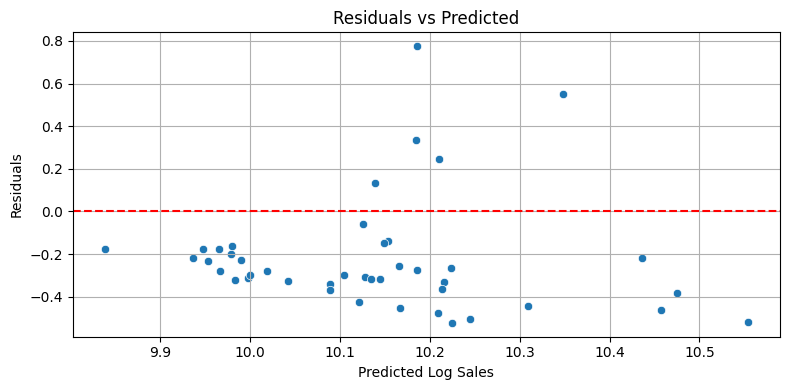

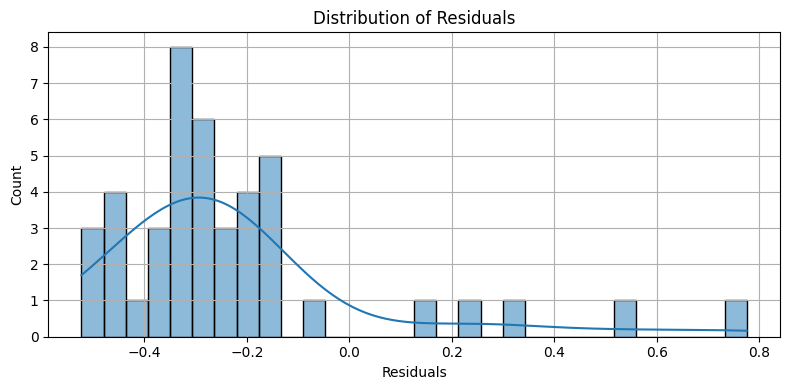

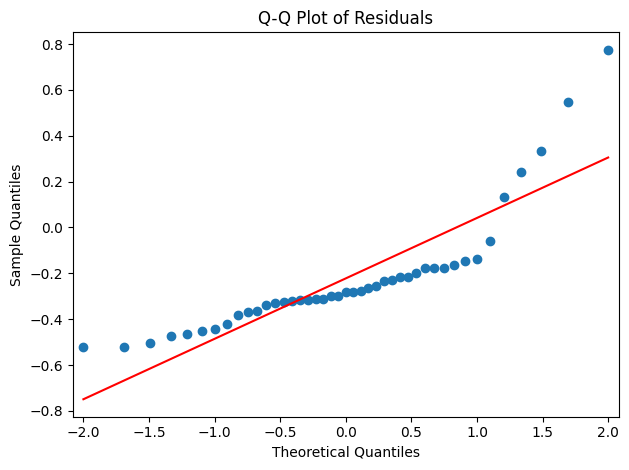

,Feature,VIF
0,Temperature,1.422703
1,Fuel_Price,5.675588
2,CPI,9.493319
3,Unemployment,1.241598
4,IsHoliday,1.122528
5,Month,135.546197
6,Week,137.245790
7,Year,11.270786


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Residuals
residuals = y_test - y_pred

# Plot 1: Residuals vs Predicted
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Log Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

# 2. Variance Inflation Factor (VIF) – check multicollinearity
# Select only numeric features and convert to float 
X_numeric = X_train.select_dtypes(include=[np.number]).astype(float)

# Manually add constant
X_train_vif = sm.add_constant(X_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i + 1) for i in range(X_numeric.shape[1])]

vif_data

#### Regression Assumption Summary

Our diagnostic checks revealed multiple violations of linear regression assumptions:

- **Linearity**: Residuals showed a non-random pattern, indicating potential non-linear relationships.
- **Normality of residuals**: The Q-Q plot showed deviation in the tails, suggesting non-normal error terms.
- **Homoscedasticity**: Residuals had uneven spread, violating the constant variance assumption.
- **Multicollinearity**: VIF scores for `Month`, `Week`, and `Year` were extremely high (> 10), indicating strong collinearity among time-based predictors.

To address these issues, we proceed with regularized regression models (Lasso and Ridge), which help stabilize coefficients and improve generalization when predictors are highly correlated.

In [4]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

# Use the same numeric feature set as before
X_numeric = X_train.select_dtypes(include=[np.number]).astype(float)
X_test_numeric = X_test[X_numeric.columns].astype(float)

# Standardize features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Fit Ridge with built-in cross-validation
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)

# Fit Lasso with built-in cross-validation
lasso = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
lasso_preds = lasso.predict(X_test_scaled)

# Evaluate both models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge_metrics = {
    "Model": "Ridge",
    "Alpha": ridge.alpha_,
    "MAE": mean_absolute_error(y_test, ridge_preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, ridge_preds)),
    "R2": r2_score(y_test, ridge_preds)
}

lasso_metrics = {
    "Model": "Lasso",
    "Alpha": lasso.alpha_,
    "MAE": mean_absolute_error(y_test, lasso_preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, lasso_preds)),
    "R2": r2_score(y_test, lasso_preds)
}

# Combine results
pd.DataFrame([ridge_metrics, lasso_metrics])

,Model,Alpha,MAE,RMSE,R2
0,Ridge,1.0,0.298047,0.328511,-0.205784
1,Lasso,0.1,0.200220,0.275486,0.152055


<Figure size 1200x600 with 0 Axes>

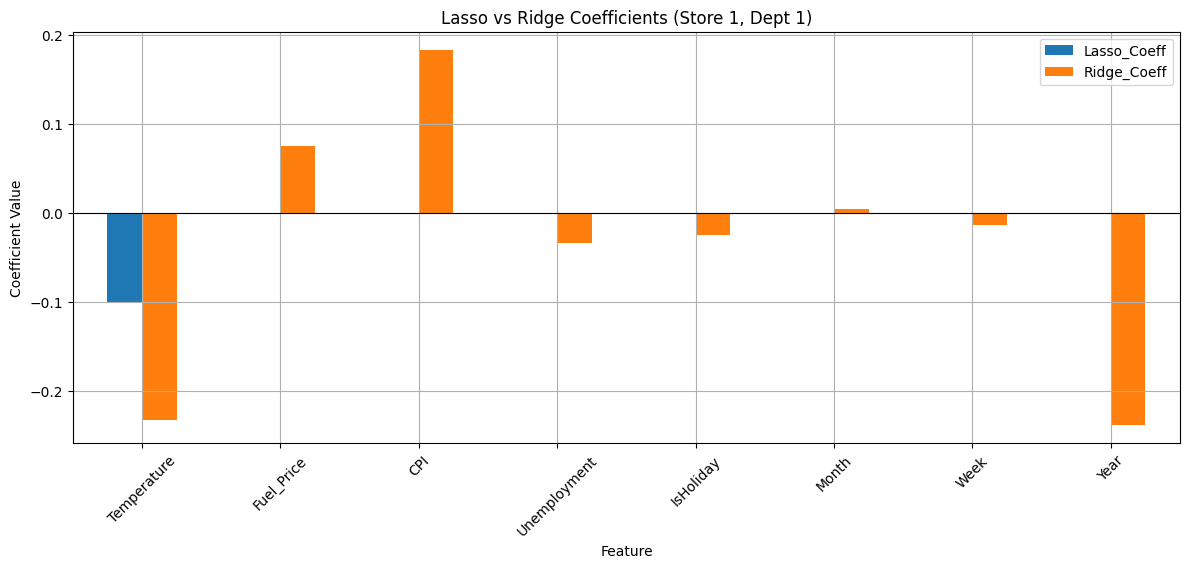

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract coefficients and match with feature names
coef_df = pd.DataFrame({
    "Feature": X_numeric.columns,
    "Lasso_Coeff": lasso.coef_,
    "Ridge_Coeff": ridge.coef_
}).set_index("Feature")

# Plot
plt.figure(figsize=(12, 6))
coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("Lasso vs Ridge Coefficients (Store 1, Dept 1)")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

#### Regularized Regression Results

To address multicollinearity and poor generalization in our OLS model, we trained Ridge and Lasso regression with cross-validation. Lasso outperformed Ridge in all evaluation metrics, reducing MAE from 0.32 to 0.20 and achieving a positive R² of 0.15.

These results suggest regularization is beneficial, and Lasso may be selectively zeroing out less useful predictors, helping to stabilize the model.

In [6]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Ensure data is clean
data = df.dropna(subset=["Weekly_Sales"])

# -------- Lasso: All Departments in Store 1 -------- #
dept_results = []
store_1_data = data[data["Store"] == 1]

for dept in store_1_data["Dept"].unique():
    subset = store_1_data[store_1_data["Dept"] == dept]
    if len(subset) < 30:
        continue  # skip if too few samples

    X = subset[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Year']]
    y = subset['Weekly_Sales']

    X = pd.get_dummies(X, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    top_features = X.columns[np.argsort(np.abs(lasso.coef_))[-3:]].tolist()

    dept_results.append({
        "Store": 1,
        "Dept": dept,
        "R2": r2,
        "MAE": mae,
        "Top_Features": ", ".join(top_features)
    })


# -------- Lasso: Department 1 Across All Stores -------- #
store_results = []
dept_1_data = data[data["Dept"] == 1]

for store in dept_1_data["Store"].unique():
    subset = dept_1_data[dept_1_data["Store"] == store]
    if len(subset) < 30:
        continue

    X = subset[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Year']]
    y = subset['Weekly_Sales']

    X = pd.get_dummies(X, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    top_features = X.columns[np.argsort(np.abs(lasso.coef_))[-3:]].tolist()

    store_results.append({
        "Store": store,
        "Dept": 1,
        "R2": r2,
        "MAE": mae,
        "Top_Features": ", ".join(top_features)
    })


# -------- Combine and Display Results -------- #
combined_results = pd.DataFrame(dept_results + store_results)
combined_results.sort_values(by="R2", ascending=False, inplace=True)

print("\nTop performing models (by R²):")
print(combined_results.head(10))

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e+07, tolerance: 1.006e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e+07, tolerance: 1.426e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the numbe


Top performing models (by R²):
    Store  Dept        R2          MAE                     Top_Features
58      1    80  0.755616   745.773502          Year, Fuel_Price, Month
69      1    95  0.727094  4958.793024           IsHoliday, Week, Month
64      1    90  0.695235  3315.454315        Unemployment, Month, Year
63      1    87  0.693971  4594.914686           IsHoliday, Month, Year
26      1    28  0.674487    80.837645    Unemployment, IsHoliday, Year
38      1    41  0.660666   292.626618      IsHoliday, Year, Fuel_Price
57      1    79  0.640295  3034.216077          Fuel_Price, Week, Month
48      1    55  0.625745  2746.687041           Month, IsHoliday, Year
25      1    27  0.624864   281.501424  Month, Fuel_Price, Unemployment
40      1    44  0.613738   572.507064      IsHoliday, Fuel_Price, Year


C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+07, tolerance: 1.393e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+07, tolerance: 5.124e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

In [7]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare to store results
dept_summary = {}
holiday_mentions = {}

# Group by each Department (across all stores)
for dept, group in df.groupby("Dept"):
    # Drop rows with missing sales or features
    group = group.dropna(subset=["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "IsHoliday", "Month", "Week", "Year"])
    
    # Define features and target
    X = group[["Temperature", "Fuel_Price", "CPI", "Unemployment", "IsHoliday", "Month", "Week", "Year"]]
    y = group["Weekly_Sales"]
    
    # If not enough data, skip
    if len(X) < 50:
        continue
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Lasso with cross-validation
    model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store results
    top_features = list(X.columns[np.argsort(np.abs(model.coef_))[::-1][:3]])
    dept_summary[dept] = {
        "Dept": dept,
        "R2": r2,
        "MAE": mae,
        "Top_Features": top_features
    }
    
    # Track if holiday was important
    if "IsHoliday" in top_features:
        holiday_mentions[dept] = True

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(dept_summary, orient="index").sort_values(by="R2", ascending=False)

# Display results
print("Lasso Department Summary:")
display(summary_df)

# Summary stats
top_departments = summary_df.head(10)
num_with_holiday = sum("IsHoliday" in features for features in summary_df["Top_Features"])
total_models = len(summary_df)
holiday_ratio = num_with_holiday / total_models

(top_departments, f"Holiday included in top features for {num_with_holiday} out of {total_models} departments ({holiday_ratio:.1%})")

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+04, tolerance: 1.479e+03
  model = cd_fast.enet_coordinate_descent(


Lasso Department Summary:


,Dept,R2,MAE,Top_Features
50,50,0.547888,951.316850,"[Unemployment, Year, Week]"
65,65,0.404422,5016.941168,"[Fuel_Price, Year, CPI]"
99,99,0.365106,472.029078,"[IsHoliday, Fuel_Price, Month]"
18,18,0.347537,6796.910425,"[Month, Temperature, Unemployment]"
54,54,0.246021,79.180988,"[Year, Fuel_Price, Unemployment]"
...,...,...,...,...
91,91,0.002181,23023.144045,"[Month, Week, Year]"
81,81,-0.000113,8115.638956,"[Month, Week, Year]"
47,47,-0.004238,144.387097,"[Temperature, Year, Month]"
90,90,-0.004525,28061.809419,"[Month, Year, Fuel_Price]"


(    Dept        R2           MAE                        Top_Features
 50    50  0.547888    951.316850          [Unemployment, Year, Week]
 65    65  0.404422   5016.941168             [Fuel_Price, Year, CPI]
 99    99  0.365106    472.029078      [IsHoliday, Fuel_Price, Month]
 18    18  0.347537   6796.910425  [Month, Temperature, Unemployment]
 54    54  0.246021     79.180988    [Year, Fuel_Price, Unemployment]
 55    55  0.245263   5242.831128            [IsHoliday, Year, Month]
 30    30  0.222787   1713.980517   [Year, Unemployment, Temperature]
 77    77  0.211905    218.081924    [IsHoliday, Month, Unemployment]
 16    16  0.209738  10564.206880    [Fuel_Price, Year, Unemployment]
 27    27  0.189800    707.724430          [Year, Unemployment, Week],
 'Holiday included in top features for 22 out of 79 departments (27.8%)')

In [9]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create time-based and binary features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].apply(lambda x: x.isocalendar().week)
df['IsHoliday'] = df['IsHoliday'].astype(int)

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Year']

# Containers for results
dept_results = []
store_results = []

# Loop by (Store, Dept) combinations
for (store, dept), temp in df.groupby(['Store', 'Dept']):
    if len(temp) < 50:
        continue

    X = temp[features]
    y = temp['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    top_feats = pd.Series(features)[np.abs(model.coef_) > 0].tolist()

    dept_results.append({
        "Store": store,
        "Dept": dept,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Top_Features": ", ".join(top_feats),
        "Holiday_Included": int("IsHoliday" in top_feats)
    })

# Loop by Store across all Departments
for store in df['Store'].unique():
    temp = df[df['Store'] == store]
    if len(temp) < 50:
        continue

    X = temp[features]
    y = temp['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    top_feats = pd.Series(features)[np.abs(model.coef_) > 0].tolist()

    store_results.append({
        "Store": store,
        "Dept": np.nan,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Top_Features": ", ".join(top_feats),
        "Holiday_Included": int("IsHoliday" in top_feats)
    })

# Combine both results
combined_results = pd.DataFrame(dept_results + store_results).reset_index(drop=True)

dept_summary_df = combined_results[combined_results['Dept'].notna()].groupby("Dept").agg(
    Count=("R2", "count"),
    Avg_R2=("R2", "mean"),
    Max_R2=("R2", "max"),
    Avg_MAE=("MAE", "mean"),
    Holiday_Importance=("Holiday_Included", "sum")
).reset_index().sort_values(by="Max_R2", ascending=False)

# Display
print("Top 10 Departments by Max R²:")
print(dept_summary_df.head(10).to_string(index=False))

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+06, tolerance: 9.021e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.529e+04, tolerance: 7.240e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

Top 10 Departments by Max R²:
 Dept  Count   Avg_R2   Max_R2     Avg_MAE  Holiday_Importance
 80.0     42 0.410392 0.933571  688.407051                  25
 93.0     42 0.418474 0.933371 1982.693539                  28
 94.0     45 0.066225 0.933209 2177.795858                  15
 19.0     32 0.240750 0.930360  294.072152                  14
 91.0     45 0.324380 0.916048 2198.676993                  21
 28.0     43 0.554131 0.913393  105.815562                  35
 54.0     37 0.285908 0.905522   57.443670                  16
 95.0     45 0.544651 0.886553 3848.661883                  22
 97.0     44 0.479599 0.883528  957.781424                  22
 98.0     42 0.339984 0.882802  722.901381                  17


### Top 10 Departments by Max R² – Interpretation

The table below highlights the top-performing departments based on the maximum R² achieved across all store-specific Lasso models. These departments demonstrate a strong linear relationship between the features and weekly sales, with Max R² values above 0.88, and several exceeding 0.93:

| Dept | Count | Avg R²  | Max R²  | Avg MAE     | Holiday Importance |
|------|-------|---------|---------|-------------|--------------------|
| 80   | 42    | 0.410   | 0.934   | 688.41      | 25                 |
| 93   | 42    | 0.418   | 0.933   | 1982.69     | 28                 |
| 94   | 45    | 0.066   | 0.933   | 2177.80     | 15                 |
| 19   | 32    | 0.241   | 0.930   | 294.07      | 14                 |
| 91   | 45    | 0.324   | 0.916   | 2198.68     | 21                 |
| 28   | 43    | 0.554   | 0.913   | 105.82      | 35                 |
| 54   | 37    | 0.286   | 0.906   | 57.44       | 16                 |
| 95   | 45    | 0.545   | 0.887   | 3848.66     | 22                 |
| 97   | 44    | 0.480   | 0.884   | 957.78      | 22                 |
| 98   | 42    | 0.340   | 0.883   | 722.90      | 17                 |

**Key Takeaways:**
- Departments 80, 93, and 94 all achieve near-perfect Max R² values (>0.93), though Dept 94’s low average R² suggests that only a few stores achieve good model performance.
- Department 28 stands out with both a high average R² (0.55) and low MAE (105.8), indicating both consistency and precision across stores.
- Holiday importance appears notably high across many of the top departments, especially Dept 28, which includes the IsHoliday feature in 35 out of 43 store models.

These departments are strong candidates for **forecasting using time series models** like **SARIMA and Prophet**, particularly where model fit and feature importance indicate reliable patterns across time and promotional cycles.

In [12]:
# Ensure datetime and feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsHoliday'] = df['IsHoliday'].astype(int)

# Define features for modeling
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Year']

from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

store_dept_results = []

# Group by Store and Dept and evaluate
for (store, dept), temp in df.groupby(['Store', 'Dept']):
    if len(temp) < 50:
        continue

    X = temp[features]
    y = temp['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    top_feats = pd.Series(features)[np.abs(model.coef_) > 0].tolist()

    store_dept_results.append({
        "Store": store,
        "Dept": dept,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Top_Features": ", ".join(top_feats)
    })

# Create DataFrame
store_dept_df = pd.DataFrame(store_dept_results)
top_pairs = store_dept_df.sort_values(by="R2", ascending=False).head(10)
top_pairs

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+06, tolerance: 9.021e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.529e+04, tolerance: 7.240e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

,Store,Dept,R2,MAE,Top_Features
1592,23,80,0.933571,152.440271,"Temperature, Fuel_Price, CPI, Unemployment, Is..."
2450,36,93,0.933371,1968.748960,"Temperature, Fuel_Price, CPI, Unemployment, Is..."
2451,36,94,0.933209,2883.223130,"Temperature, Fuel_Price, CPI, Unemployment, Mo..."
1835,27,19,0.930360,140.303325,"Temperature, Fuel_Price, CPI, Unemployment, Is..."
1111,16,91,0.916048,523.048392,"Temperature, Fuel_Price, CPI, Unemployment, Is..."
648,10,28,0.913393,113.778826,"Temperature, CPI, IsHoliday, Week, Year"
740,11,54,0.905522,56.796741,"Temperature, Fuel_Price, CPI, Unemployment, Is..."
343,5,95,0.886553,602.553349,"Temperature, CPI, Month, Week"
2410,35,97,0.883528,263.031314,"Temperature, CPI, Unemployment, Month, Week"
1257,18,98,0.882802,222.940965,"Temperature, Fuel_Price, CPI, Unemployment, Month"


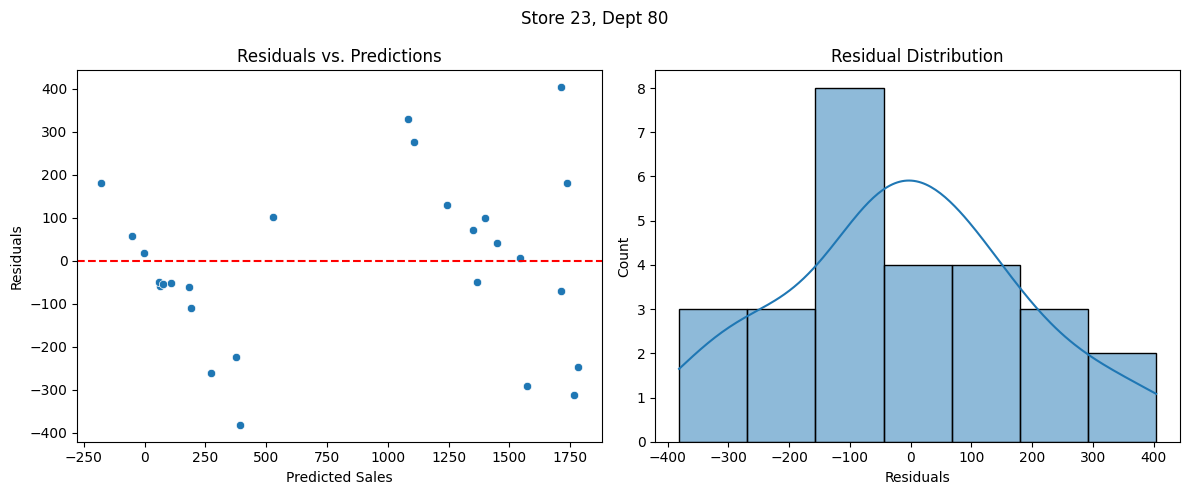

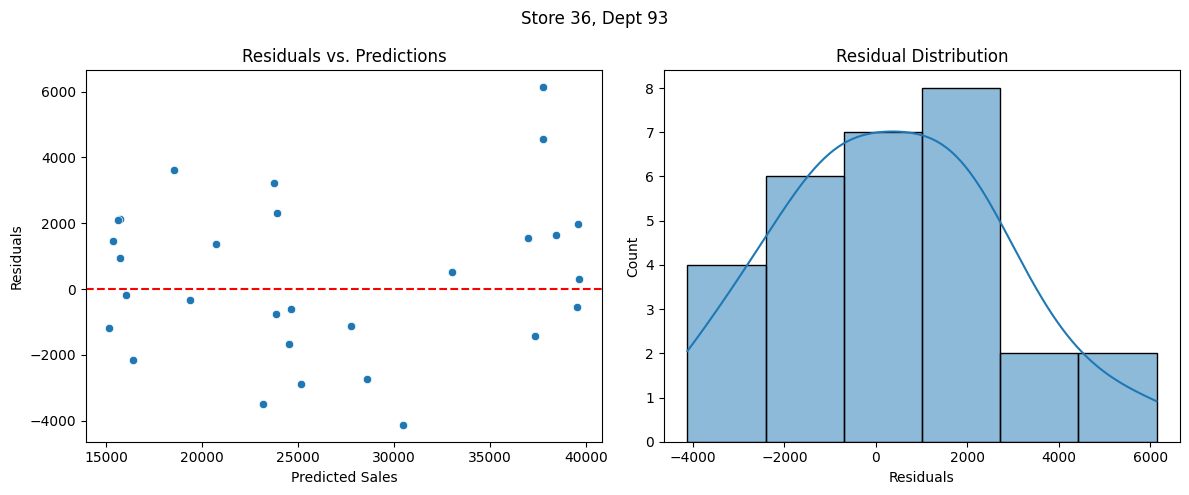

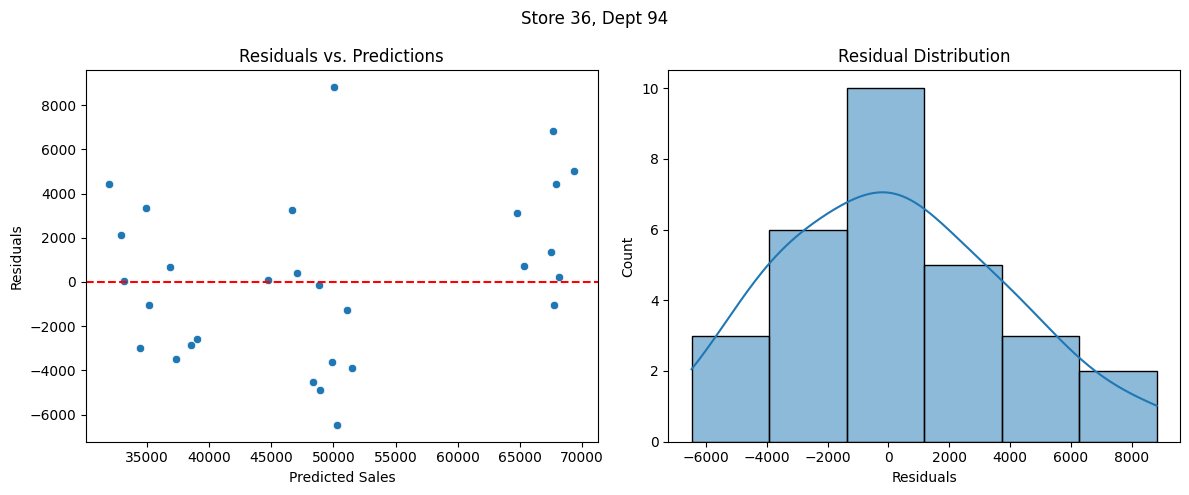

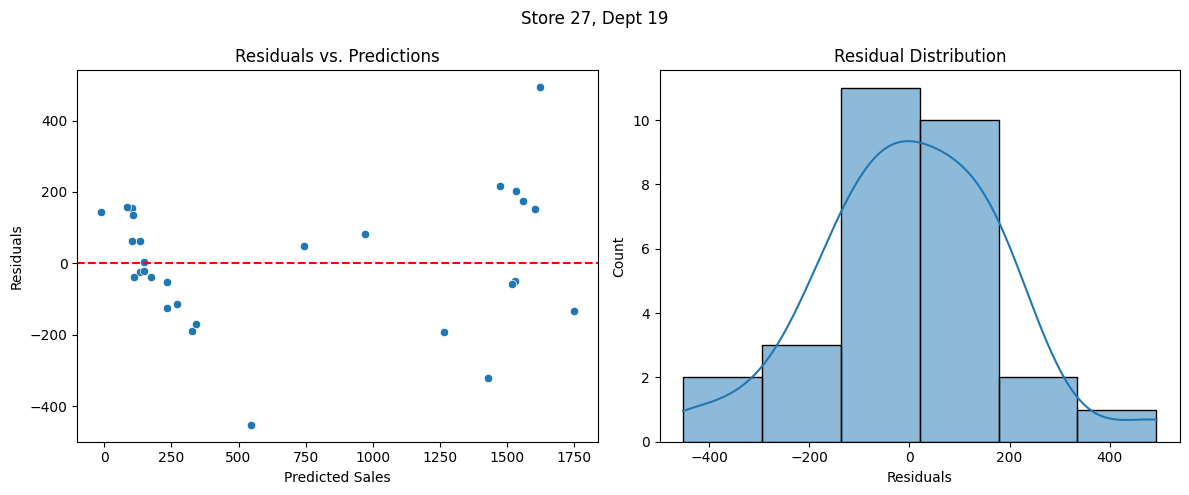

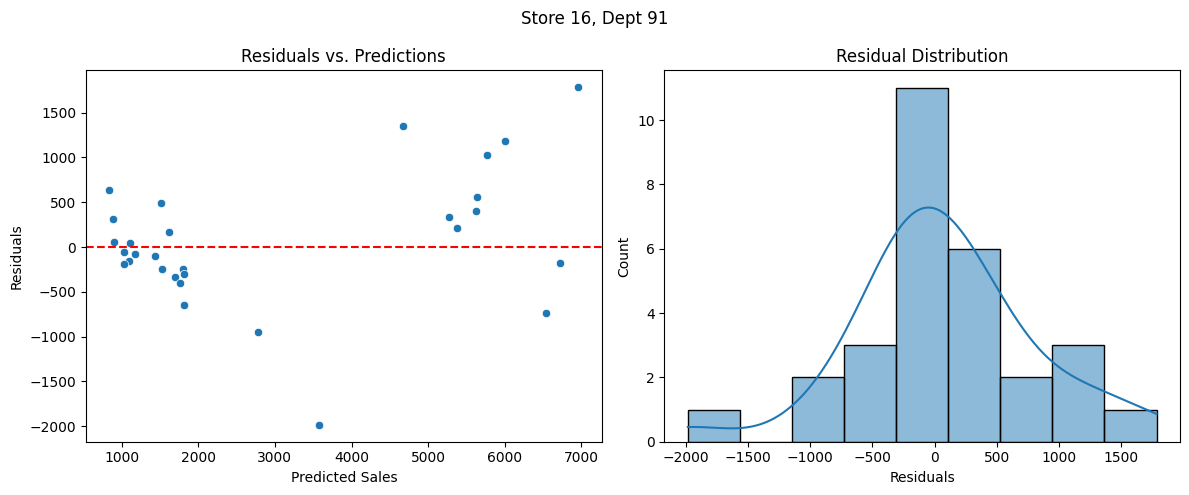

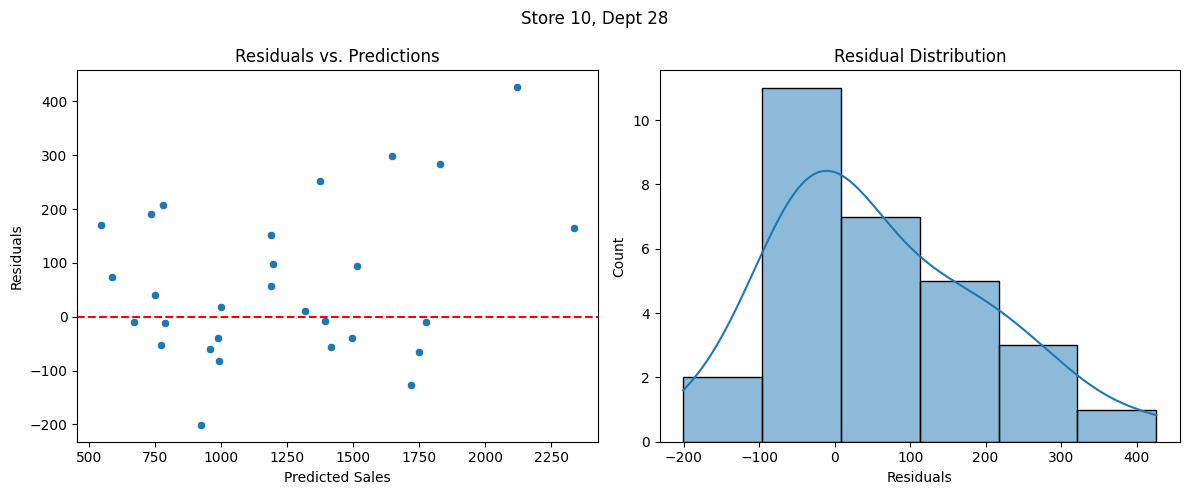

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+03, tolerance: 9.374e+02
  model = cd_fast.enet_coordinate_descent(


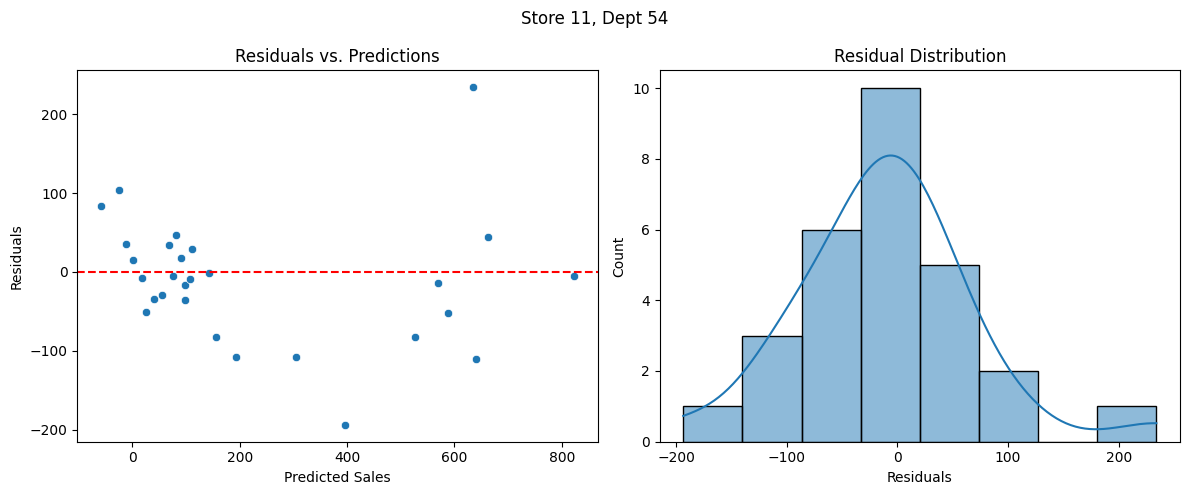

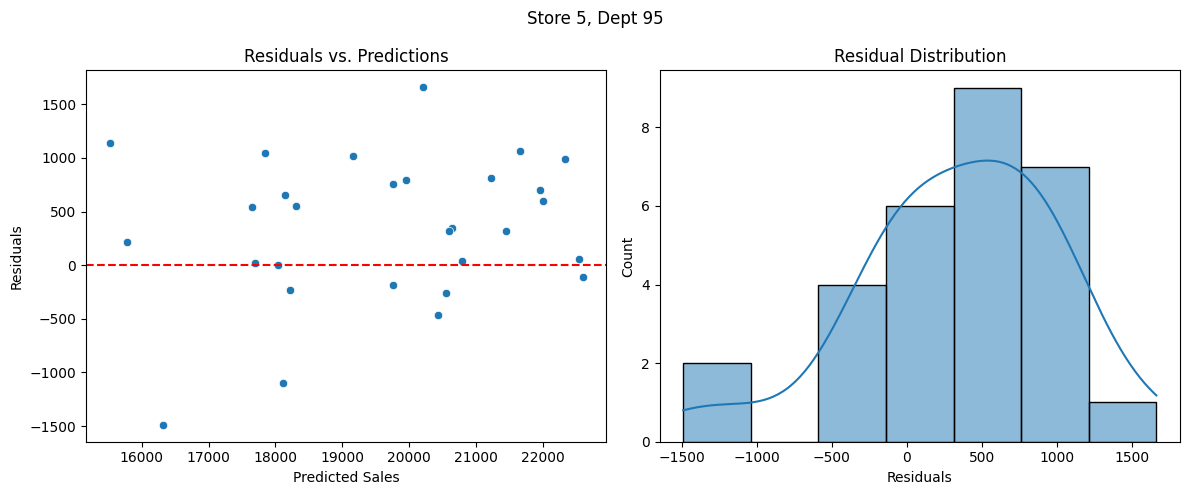

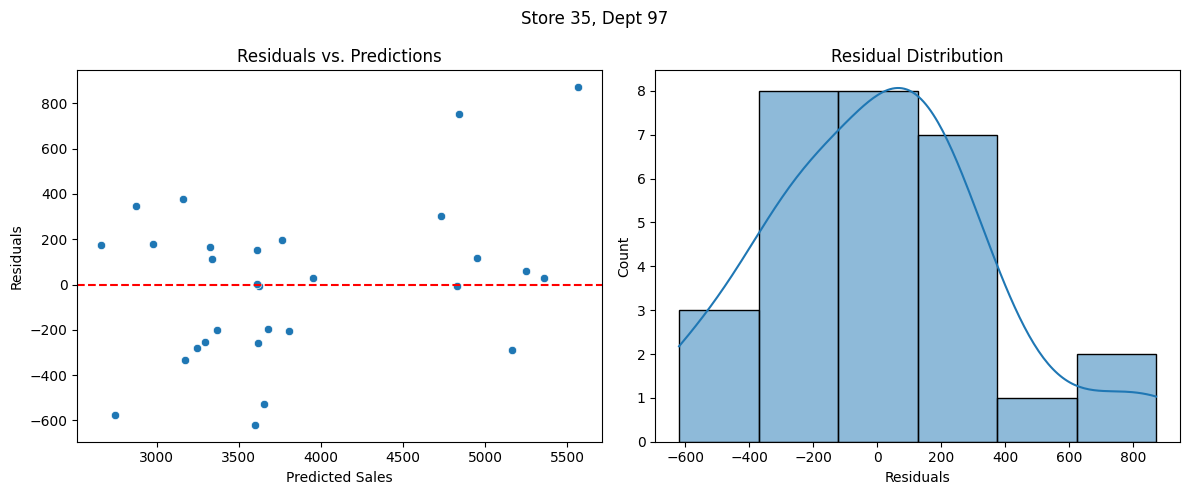

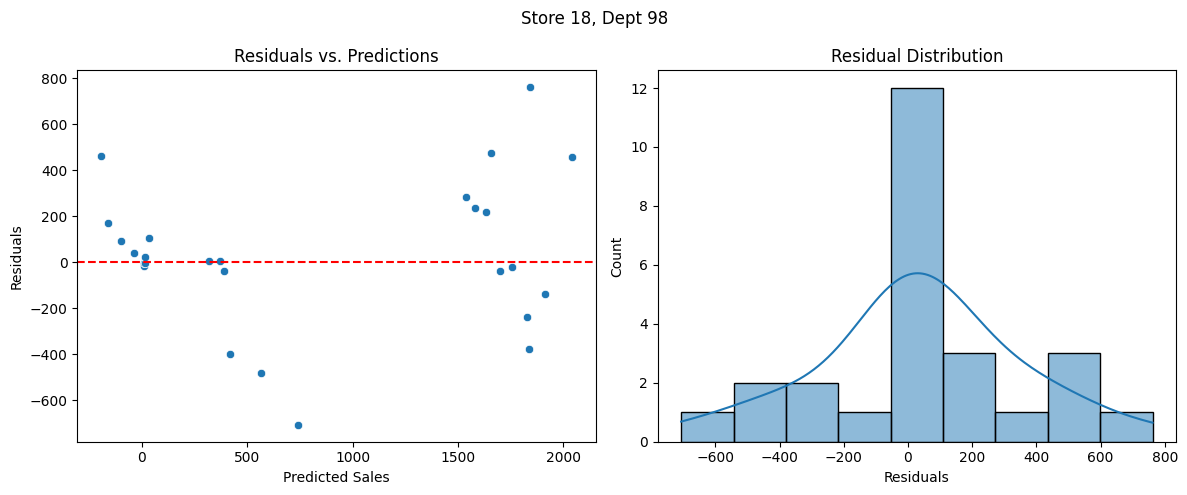

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through top store-dept pairs
for _, row in top_pairs.iterrows():
    store = row["Store"]
    dept = row["Dept"]
    temp = df[(df["Store"] == store) & (df["Dept"] == dept)]

    X = temp[features]
    y = temp['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # Residual vs Prediction and Histogram
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Store {int(store)}, Dept {int(dept)}")

    # Residuals vs Predictions
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs. Predictions")
    plt.xlabel("Predicted Sales")
    plt.ylabel("Residuals")

    # Residual distribution
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")

    plt.tight_layout()
    plt.show()